Setup Environment

In [28]:
# Import libraries and modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Set the style of the plots
sns.set_theme(style="whitegrid")


Define the constants and mappings

In [3]:
raw_data_dir = "../data/raw"
# List of Travistorrent files
input_files = [
    "travistorrent-2015.csv",
    "travistorrent-2016.csv",
    "travistorrent-2017.csv"
]

# Mapping for 2015
columns_mapping_2015 = {
    "status": "tr_status",
    "project_name": "gh_project_name",
    "is_pr": "gh_is_pr",
    "main_team_member": "gh_by_core_team_member",
    "team_size": "gh_team_size",
    "sloc": "gh_sloc",
    "started_at": "gh_build_started_at",
    "num_commits": "git_num_commits",
    "num_commit_comments": "gh_num_commit_comments",
    "src_churn": "gh_src_churn",
    "test_churn": "gh_test_churn",
    "files_added": "gh_files_added",
    "files_deleted": "gh_files_deleted",
    "files_modified": "gh_files_modified",
    "tests_added": "gh_tests_added",
    "tests_deleted": "gh_tests_deleted",
    "src_files": "gh_src_files",
    "doc_files": "gh_doc_files",
    "other_files": "gh_other_files",
    "commits_on_files_touched": "gh_commits_on_files_touched",
    "test_lines_per_kloc": "gh_test_lines_per_kloc",
    "test_cases_per_kloc": "gh_test_cases_per_kloc",
    "asserts_per_kloc": "gh_asserts_cases_per_kloc"
}

# Mapping for 2016 and 2017
columns_mapping_2016_2017 = {
    "tr_status": "tr_status",
    "gh_project_name": "gh_project_name",
    "gh_is_pr": "gh_is_pr",
    "gh_by_core_team_member": "gh_by_core_team_member",
    "gh_team_size": "gh_team_size",
    "gh_sloc": "gh_sloc",
    "tr_started_at": "gh_build_started_at",
    "git_num_commits": "git_num_commits",
    "gh_num_commit_comments": "gh_num_commit_comments",
    "gh_src_churn": "gh_src_churn",
    "gh_test_churn": "gh_test_churn",
    "gh_files_added": "gh_files_added",
    "gh_files_deleted": "gh_files_deleted",
    "gh_files_modified": "gh_files_modified",
    "gh_tests_added": "gh_tests_added",
    "gh_tests_deleted": "gh_tests_deleted",
    "gh_src_files": "gh_src_files",
    "gh_doc_files": "gh_doc_files",
    "gh_other_files": "gh_other_files",
    "gh_commits_on_files_touched": "gh_commits_on_files_touched",
    "gh_test_lines_per_kloc": "gh_test_lines_per_kloc",
    "gh_test_cases_per_kloc": "gh_test_cases_per_kloc",
    "gh_asserts_cases_per_kloc": "gh_asserts_cases_per_kloc"
}

dtype_spec = {
    "git_diff_src_churn": "float32",
    "gh_diff_files_modified": "float32",
    "gh_test_lines_per_kloc": "float32"
}

Load and Combine Raw Data

In [21]:
"""Load and concatenate multiple Travistorrent CSV files"""
dataframes = []
for file in input_files:
    file_path = os.path.join(raw_data_dir, file)
    if os.path.exists(file_path):
        df_chunk = pd.read_csv(file_path, dtype=dtype_spec, low_memory=False)
        if "2015" in file:
            df_chunk.rename(columns=columns_mapping_2015, inplace=True)
        else:
            df_chunk.rename(columns=columns_mapping_2016_2017, inplace=True)
            
        columns_to_keep = list(set(columns_mapping_2015.values()) & set(columns_mapping_2016_2017.values()))
        available_columns = [col for col in columns_to_keep if col in df_chunk.columns]
        filtered_df = df_chunk[available_columns].copy()
        dataframes.append(filtered_df)
    else:
        print(f"File {file} not found. Skipping...")
if not dataframes:
    raise FileNotFoundError("No files found in the list")


# Load and combine data
combined_df = pd.concat(dataframes, ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

# Quick inspection
print("\nDataset info:")
print(combined_df.info())
print("\nFirst 5 rows:")
print(combined_df.head())

/tmp/ipykernel_3644/4155014334.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dataframes, ignore_index=True)


Combined dataset shape: (8895472, 23)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895472 entries, 0 to 8895471
Data columns (total 23 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   git_num_commits              float64
 1   tr_status                    object 
 2   gh_tests_added               float64
 3   gh_test_cases_per_kloc       float64
 4   gh_by_core_team_member       object 
 5   gh_src_churn                 float64
 6   gh_build_started_at          object 
 7   gh_files_modified            float64
 8   gh_project_name              object 
 9   gh_is_pr                     bool   
 10  gh_other_files               float64
 11  gh_doc_files                 float64
 12  gh_src_files                 float64
 13  gh_files_added               float64
 14  gh_num_commit_comments       int64  
 15  gh_test_lines_per_kloc       float32
 16  gh_files_deleted             float64
 17  gh_asserts_cases_per_kloc    fl

Data Preprocessing

In [23]:
# Rename and convert target column 
combined_df.rename(columns={"tr_status": "build_failed"}, inplace=True)
combined_df["build_failed"] = combined_df["build_failed"].map({"passed": 0, "failed": 1, "errored": 1, "canceled": 1})

# Print missing values information and rows with missing values
missing_count = combined_df.isna().sum()
missing_ratio = (missing_count / len(combined_df)) * 100
missing_df = pd.DataFrame({'missing_count': missing_count, 'missing_ratio (%)': missing_ratio})
print(missing_df.sort_values(by='missing_count', ascending=False))
rows_with_na = combined_df[combined_df.isna().any(axis=1)]
print("Shape of rows with missing values:", rows_with_na.shape)
print(rows_with_na.head(10))

# Drop rows with missing values
columns_required = ["build_failed", "gh_project_name", "gh_build_started_at"] # Only columns can not fill with default values
before_drop = len(combined_df)
combined_df.dropna(subset=columns_required, inplace=True)
print(f"\nDropped {before_drop - len(combined_df)} rows missing critical columns. New shape: {combined_df.shape}")

# Drop duplicates
num_duplicates = combined_df.duplicated().sum()
print(f"\nNumber of duplicates: {num_duplicates}")
initial_rows = len(combined_df)
combined_df.drop_duplicates(inplace=True)
print(f"\nDropped {initial_rows - len(combined_df)} duplicates. New shape: {combined_df.shape}")

# Check if DataFrame is empty after duplicates
if combined_df.empty:
    raise ValueError("DataFrame is empty after dropping duplicates. Check duplicate criteria or data quality.")

# Encode categorical columns
categorical_columns = ["gh_is_pr", "gh_by_core_team_member"]
label_encoders = {}
for col in categorical_columns:
    if col in combined_df.columns:
        le = LabelEncoder()
        combined_df[col] = le.fit_transform(combined_df[col].astype(str))
        label_encoders[col] = le
    else:
        print(f"Column {col} not found in the dataset. Skipping...")

# Normalize numerical columns
numerical_columns = [
    "git_num_commits",
    "gh_num_commit_comments",
    "gh_src_churn",
    "gh_test_churn",
    "gh_files_added",
    "gh_files_deleted",
    "gh_files_modified",
    "gh_tests_added",
    "gh_tests_deleted",
    "gh_src_files",
    "gh_doc_files",
    "gh_other_files",
    "gh_commits_on_files_touched",
    "gh_sloc",
    "gh_test_lines_per_kloc",
    "gh_test_cases_per_kloc",
    "gh_asserts_cases_per_kloc",
    "gh_team_size"
]
scaler = MinMaxScaler()
combined_df[numerical_columns] = scaler.fit_transform(combined_df[numerical_columns].fillna(0))
print("\nDataset after encoding and normalization:")
print(combined_df.head())
print(f"Final shape: {combined_df.shape}")

                             missing_count  missing_ratio (%)
gh_tests_added                     6254647          70.312705
gh_src_churn                       6254647          70.312705
gh_files_added                     6254647          70.312705
gh_doc_files                       6254647          70.312705
gh_src_files                       6254647          70.312705
gh_other_files                     6254647          70.312705
gh_files_modified                  6254647          70.312705
gh_commits_on_files_touched        6254647          70.312705
gh_tests_deleted                   6254647          70.312705
gh_test_churn                      6254647          70.312705
gh_files_deleted                   6254647          70.312705
git_num_commits                    3881992          43.640090
gh_asserts_cases_per_kloc          2372655          26.672615
gh_test_cases_per_kloc             2372655          26.672615
gh_by_core_team_member             2372655          26.672615
gh_team_

Print imbalance information

Class distribution:
build_failed
0.0    0.729605
1.0    0.270395
Name: proportion, dtype: float64


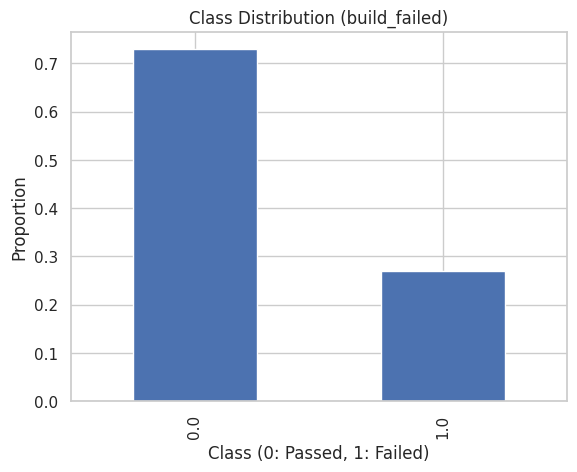

In [24]:
imbalance = combined_df['build_failed'].value_counts(normalize=True)
print("Class distribution:")
print(imbalance)

# Plot class distribution
imbalance.plot(kind='bar', title='Class Distribution (build_failed)')
plt.xlabel('Class (0: Passed, 1: Failed)')
plt.ylabel('Proportion')
plt.show()

Print top 20 projects by number of rows

Top 20 Projects by Number of Rows:
gh_project_name
apache/jackrabbit-oak               19678
opf/openproject                     17045
ros/rosdistro                       16969
apache/sling                        15386
jruby/jruby                         13217
CartoDB/cartodb                     12214
getsentry/sentry                    11725
CloudifySource/cloudify             11420
Graylog2/graylog2-server            10366
cloudfoundry/cloud_controller_ng     8800
ets-berkeley-edu/calcentral          8430
rg3/youtube-dl                       8269
cloudfoundry/bosh                    8159
gradle/gradle                        7406
orbeon/orbeon-forms                  7372
spree/spree                          7099
sharetribe/sharetribe                6967
opal/opal                            6824
projecthydra/sufia                   6231
bbatsov/rubocop                      6150
Name: count, dtype: int64


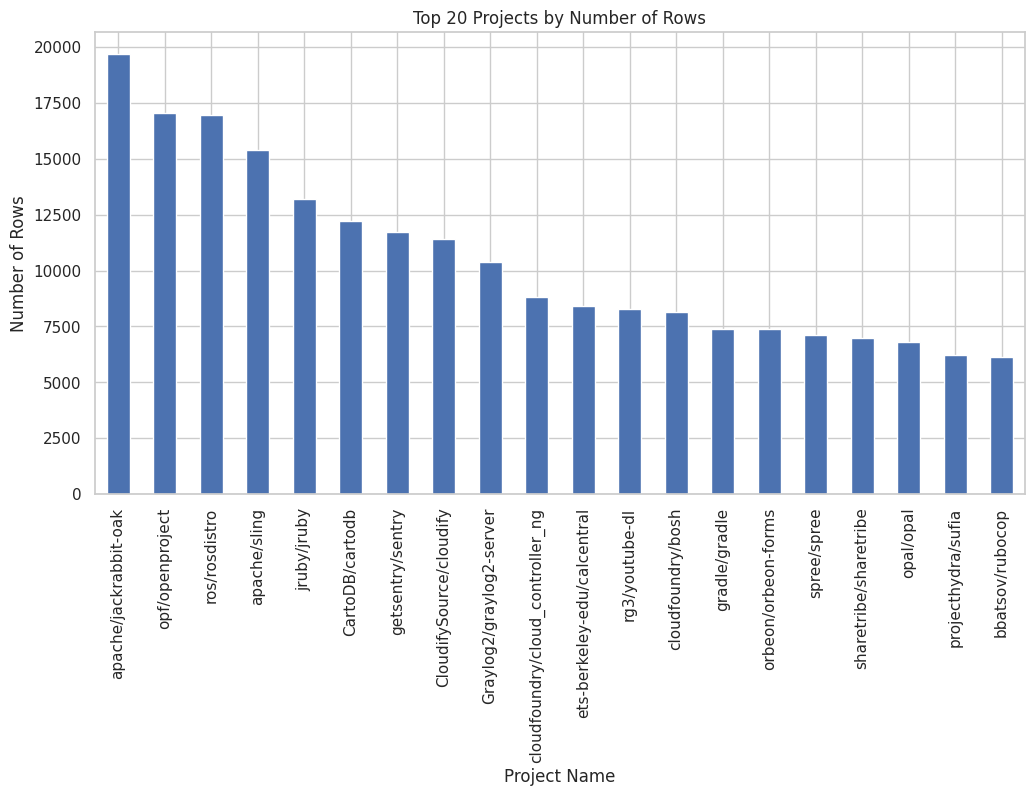

In [25]:
project_counts = combined_df['gh_project_name'].value_counts().head(20)
print("Top 20 Projects by Number of Rows:")
print(project_counts)

# Plot top 20 projects by number of rows
project_counts.plot(kind='bar', figsize=(12, 6), title='Top 20 Projects by Number of Rows')
plt.xlabel('Project Name')
plt.ylabel('Number of Rows')
plt.xticks(rotation=90)
plt.show()

Print balance degree and class distribution

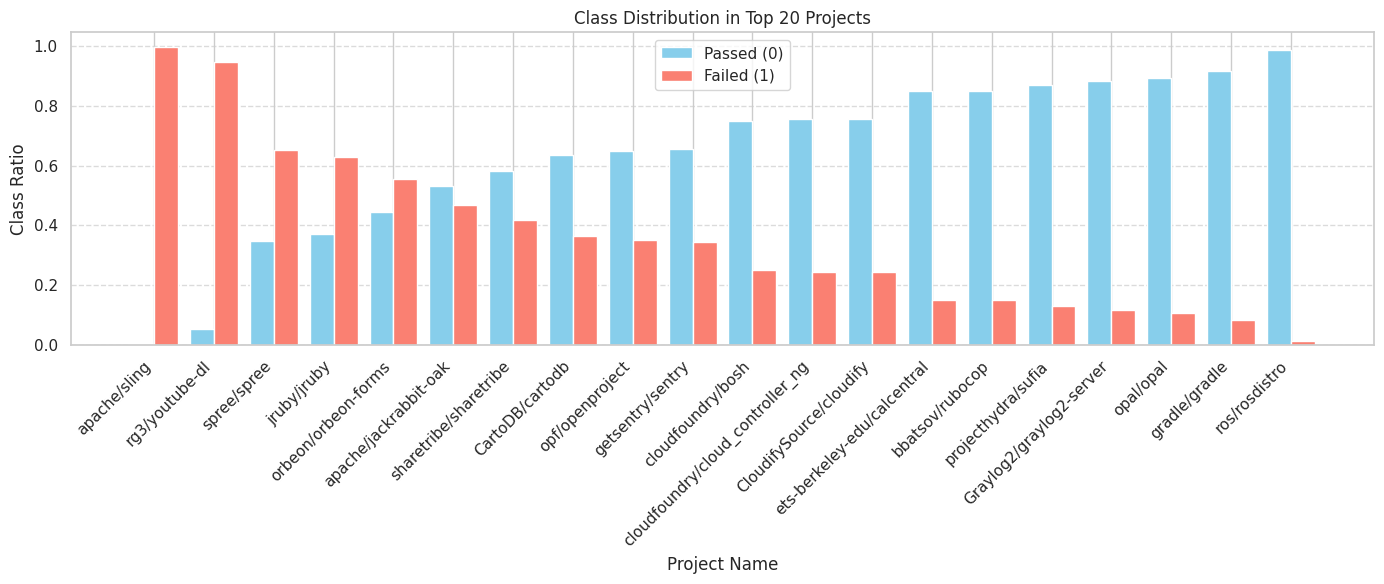

                             project  failed_ratio  passed_ratio  total_rows
0              apache/jackrabbit-oak      0.467375      0.532625       19678
1                    opf/openproject      0.352655      0.647345       17045
2                      ros/rosdistro      0.013672      0.986328       16969
3                       apache/sling      0.994540      0.005460       15386
4                        jruby/jruby      0.627298      0.372702       13217
5                    CartoDB/cartodb      0.365892      0.634108       12214
6                   getsentry/sentry      0.344136      0.655864       11725
7            CloudifySource/cloudify      0.243783      0.756217       11420
8           Graylog2/graylog2-server      0.118754      0.881246       10366
9   cloudfoundry/cloud_controller_ng      0.245341      0.754659        8800
10       ets-berkeley-edu/calcentral      0.152906      0.847094        8430
11                    rg3/youtube-dl      0.946426      0.053574        8269

In [30]:
# Calculate class distribution for each project
balance_data = []
for project in project_counts.index:
    project_df = combined_df[combined_df['gh_project_name'] == project]
    class_counts = project_df['build_failed'].value_counts(normalize=True)
    failed_ratio = class_counts.get(1.0, 0.0)
    passed_ratio = class_counts.get(0.0, 0.0)
    balance_data.append({
        'project': project,
        'failed_ratio': failed_ratio,
        'passed_ratio': passed_ratio,
        'total_rows': len(project_df)
    })

# Create DataFrame and sort by failed ratio
balance_df = pd.DataFrame(balance_data)
balance_df = balance_df.sort_values(by='failed_ratio', ascending=False)

# Plot class distribution for top 20 projects
plt.figure(figsize=(14, 6))
bar_width = 0.4
x = np.arange(len(balance_df))

plt.bar(x - bar_width/2, balance_df['passed_ratio'], width=bar_width, label='Passed (0)', color='skyblue')
plt.bar(x + bar_width/2, balance_df['failed_ratio'], width=bar_width, label='Failed (1)', color='salmon')

plt.xticks(ticks=x, labels=balance_df['project'], rotation=45, ha='right')
plt.xlabel('Project Name')
plt.ylabel('Class Ratio')
plt.title('Class Distribution in Top 20 Projects')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print class distribution for top 20 projects
print(balance_df[['project', 'failed_ratio', 'passed_ratio', 'total_rows']].sort_index())


Save data by project

In [ ]:
output_data_dir = "data/processed"

top_projects = project_counts.index
for project in top_projects:
    project_df = combined_df[combined_df['gh_project_name'] == project]
    file_name = project.replace("/", "_").replace(":", "_").replace(" ", "_") + ".csv"
    project_df.to_csv(os.path.join(output_data_dir, file_name), index=False)
    print(f"Saved {file_name} with {len(project_df)} rows")